# Lab Week 5 Task 1 Code
Code Accompanying the Chapter 5: Predictive Analytics with Ensemble Learning of the Book: **Classification and Regression Using Supervised Learning, A., Joshi, P. (2020)**

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as sm
from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, explained_variance_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, LinearSVC
from sklearn.utils import shuffle


In [2]:
def visualize_classifier(classifier, X, y):
    # Define the minimum and maximum values for X and Y
    # that will be used in the mesh grid
    min_x, max_x = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    min_y, max_y = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    # Define the step size to use in plotting the mesh grid 
    mesh_step_size = 0.01

    # Define the mesh grid of X and Y values
    x_vals, y_vals = np.meshgrid(np.arange(min_x, max_x, mesh_step_size), np.arange(min_y, max_y, mesh_step_size))

    # Run the classifier on the mesh grid
    output = classifier.predict(np.c_[x_vals.ravel(), y_vals.ravel()])

    # Reshape the output array
    output = output.reshape(x_vals.shape)

    # Create a plot
    plt.figure()

    # Choose a color scheme for the plot 
    plt.pcolormesh(x_vals, y_vals, output, cmap=plt.cm.gray)

    # Overlay the training points on the plot 
    plt.scatter(X[:, 0], X[:, 1], c=y, s=75, edgecolors='black', linewidth=1, cmap=plt.cm.Paired)

    # Specify the boundaries of the plot
    plt.xlim(x_vals.min(), x_vals.max())
    plt.ylim(y_vals.min(), y_vals.max())

    # Specify the ticks on the X and Y axes
    plt.xticks((np.arange(int(X[:, 0].min() - 1), int(X[:, 0].max() + 1), 1.0)))
    plt.yticks((np.arange(int(X[:, 1].min() - 1), int(X[:, 1].max() + 1), 1.0)))

    plt.show()



## Preprocessing data

In [3]:
input_data = np.array([[5.1, -2.9, 3.3],
                       [-1.2, 7.8, -6.1],
                       [3.9, 0.4, 2.1],
                       [7.3, -9.9, -4.5]])

# Binarize data 
data_binarized = preprocessing.Binarizer(threshold=2.1).transform(input_data)
print("\nBinarized data:\n", data_binarized)

# Print mean and standard deviation
print("\nBEFORE:")
print("Mean =", input_data.mean(axis=0))
print("Std deviation =", input_data.std(axis=0))

# Remove mean
data_scaled = preprocessing.scale(input_data)
print("\nAFTER:")
print("Mean =", data_scaled.mean(axis=0))
print("Std deviation =", data_scaled.std(axis=0))

# Min max scaling
data_scaler_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_scaled_minmax = data_scaler_minmax.fit_transform(input_data)
print("\nMin max scaled data:\n", data_scaled_minmax)

# Normalize data
data_normalized_l1 = preprocessing.normalize(input_data, norm='l1')
data_normalized_l2 = preprocessing.normalize(input_data, norm='l2')
print("\nL1 normalized data:\n", data_normalized_l1)
print("\nL2 normalized data:\n", data_normalized_l2)




Binarized data:
 [[1. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

BEFORE:
Mean = [ 3.775 -1.15  -1.3  ]
Std deviation = [3.12039661 6.36651396 4.0620192 ]

AFTER:
Mean = [1.11022302e-16 0.00000000e+00 2.77555756e-17]
Std deviation = [1. 1. 1.]

Min max scaled data:
 [[0.74117647 0.39548023 1.        ]
 [0.         1.         0.        ]
 [0.6        0.5819209  0.87234043]
 [1.         0.         0.17021277]]

L1 normalized data:
 [[ 0.45132743 -0.25663717  0.2920354 ]
 [-0.0794702   0.51655629 -0.40397351]
 [ 0.609375    0.0625      0.328125  ]
 [ 0.33640553 -0.4562212  -0.20737327]]

L2 normalized data:
 [[ 0.75765788 -0.43082507  0.49024922]
 [-0.12030718  0.78199664 -0.61156148]
 [ 0.87690281  0.08993875  0.47217844]
 [ 0.55734935 -0.75585734 -0.34357152]]


In [4]:
import numpy as np
from sklearn import preprocessing

# Sample input labels
input_labels = ['red', 'black', 'red', 'green', 'black', 'yellow', 'white']

# Create label encoder and fit the labels
encoder = preprocessing.LabelEncoder()
encoder.fit(input_labels)

# Print the mapping 
print("\nLabel mapping:")
for i, item in enumerate(encoder.classes_):
    print(item, '-->', i)

# Encode a set of labels using the encoder
test_labels = ['green', 'red', 'black']
encoded_values = encoder.transform(test_labels)
print("\nLabels =", test_labels)
print("Encoded values =", list(encoded_values))

# Decode a set of values using the encoder
encoded_values = [3, 0, 4, 1]
decoded_list = encoder.inverse_transform(encoded_values)
print("\nEncoded values =", encoded_values)
print("Decoded labels =", list(decoded_list))



Label mapping:
black --> 0
green --> 1
red --> 2
white --> 3
yellow --> 4

Labels = ['green', 'red', 'black']
Encoded values = [1, 2, 0]

Encoded values = [3, 0, 4, 1]
Decoded labels = ['white', 'black', 'yellow', 'green']


## Logistic regression classifiers

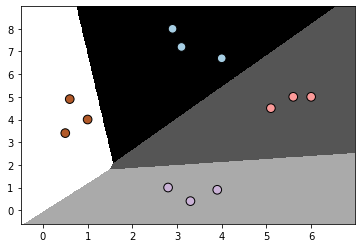

In [5]:
import numpy as np
from sklearn import linear_model 
import matplotlib.pyplot as plt


# Define sample input data
X = np.array([[3.1, 7.2], [4, 6.7], [2.9, 8], [5.1, 4.5], [6, 5], [5.6, 5], [3.3, 0.4], [3.9, 0.9], [2.8, 1], [0.5, 3.4], [1, 4], [0.6, 4.9]])
y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

# Create the logistic regression classifier
classifier = linear_model.LogisticRegression(solver='liblinear', C=1)
#classifier = linear_model.LogisticRegression(solver='liblinear', C=100)

# Train the classifier
classifier.fit(X, y)

# Visualize the performance of the classifier 
visualize_classifier(classifier, X, y)


## The Naïve Bayes classifier

Accuracy of Naive Bayes classifier = 99.75 %


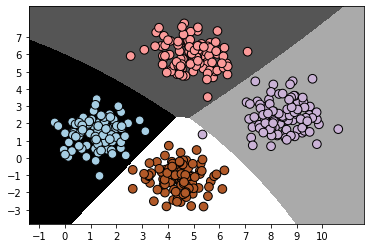

Accuracy of the new classifier = 100.0 %


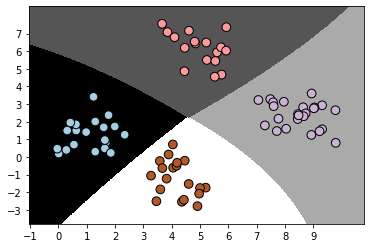

Accuracy: 99.75%
Precision: 99.76%
Recall: 99.75%
F1: 99.75%


In [6]:


# Input file containing data
input_file = 'data_multivar_nb.txt'

# Load data from input file
data = np.loadtxt(input_file, delimiter=',')
X, y = data[:, :-1], data[:, -1] 

# Create Naive Bayes classifier 
classifier = GaussianNB()

# Train the classifier
classifier.fit(X, y)

# Predict the values for training data
y_pred = classifier.predict(X)

# Compute accuracy
accuracy = 100.0 * (y == y_pred).sum() / X.shape[0]
print("Accuracy of Naive Bayes classifier =", round(accuracy, 2), "%")

# Visualize the performance of the classifier
visualize_classifier(classifier, X, y)

###############################################
# Cross validation 

# Split data into training and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
classifier_new = GaussianNB()
classifier_new.fit(X_train, y_train)
y_test_pred = classifier_new.predict(X_test)

# compute accuracy of the classifier
accuracy = 100.0 * (y_test == y_test_pred).sum() / X_test.shape[0]
print("Accuracy of the new classifier =", round(accuracy, 2), "%")

# Visualize the performance of the classifier
visualize_classifier(classifier_new, X_test, y_test)

###############################################
# Scoring functions

num_folds = 3
accuracy_values = cross_val_score(classifier, 
        X, y, scoring='accuracy', cv=num_folds)
print("Accuracy: " + str(round(100*accuracy_values.mean(), 2)) + "%")

precision_values = cross_val_score(classifier, 
        X, y, scoring='precision_weighted', cv=num_folds)
print("Precision: " + str(round(100*precision_values.mean(), 2)) + "%")

recall_values = cross_val_score(classifier, 
        X, y, scoring='recall_weighted', cv=num_folds)
print("Recall: " + str(round(100*recall_values.mean(), 2)) + "%")

f1_values = cross_val_score(classifier, 
        X, y, scoring='f1_weighted', cv=num_folds)
print("F1: " + str(round(100*f1_values.mean(), 2)) + "%")



## Confusion matrixes
(More on that in this week's lecture.)

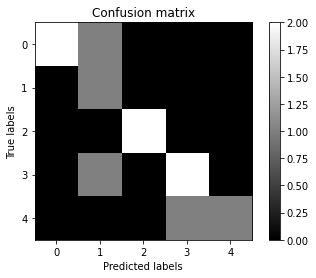


               precision    recall  f1-score   support

     Class-0       1.00      0.67      0.80         3
     Class-1       0.33      1.00      0.50         1
     Class-2       1.00      1.00      1.00         2
     Class-3       0.67      0.67      0.67         3
     Class-4       1.00      0.50      0.67         2

    accuracy                           0.73        11
   macro avg       0.80      0.77      0.73        11
weighted avg       0.85      0.73      0.75        11



In [7]:
# Define sample labels
true_labels = [2, 0, 0, 2, 4, 4, 1, 0, 3, 3, 3]
pred_labels = [2, 1, 0, 2, 4, 3, 1, 0, 1, 3, 3]

# Create confusion matrix
confusion_mat = confusion_matrix(true_labels, pred_labels)

# Visualize confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

# Classification report
targets = ['Class-0', 'Class-1', 'Class-2', 'Class-3', 'Class-4']
print('\n', classification_report(true_labels, pred_labels, target_names=targets))



## Classifying income data using Support Vector Machines

In [17]:

# Input file containing data
input_file = 'income_data.txt'

# Read the data
X = []
y = []
count_class1 = 0
count_class2 = 0
max_datapoints = 25000

with open(input_file, 'r') as f:
    for line in f.readlines():
        if count_class1 >= max_datapoints and count_class2 >= max_datapoints:
            break

        if '?' in line:
            continue

        data = line[:-1].split(', ')

        if data[-1] == '<=50K' and count_class1 < max_datapoints:
            X.append(data)
            count_class1 += 1

        if data[-1] == '>50K' and count_class2 < max_datapoints:
            X.append(data)
            count_class2 += 1

# Convert to numpy array
X = np.array(X)

# Convert string data to numerical data
label_encoder = [] 
X_encoded = np.empty(X.shape)
for i,item in enumerate(X[0]):
    if item.isdigit(): 
        X_encoded[:, i] = X[:, i]
    else:
        label_encoder.append(preprocessing.LabelEncoder())
        X_encoded[:, i] = label_encoder[-1].fit_transform(X[:, i])

X = X_encoded[:, :-1].astype(int)
y = X_encoded[:, -1].astype(int)

# Create SVM classifier
classifier = OneVsOneClassifier(LinearSVC(random_state=0))

# Train the classifier
classifier.fit(X, y)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
classifier = OneVsOneClassifier(LinearSVC(random_state=0))
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

# Compute the F1 score of the SVM classifier
f1 = cross_val_score(classifier, X, y, scoring='f1_weighted', cv=3)
print("F1 score: " + str(round(100*f1.mean(), 2)) + "%")

# Predict output for a test datapoint
input_data = ['37', 'Private', '215646', 'HS-grad', '9', 'Never-married', 'Handlers-cleaners', 'Not-in-family', 'White', 'Male', '0', '0', '40', 'United-States']

# Encode test datapoint
input_data_encoded = [-1] * len(input_data)
count = 0
for i, item in enumerate(input_data):
    if item.isdigit():
        input_data_encoded[i] = int(input_data[i])
    else:
        input_data_encoded[i] = int(label_encoder[count].transform([input_data[i]]))
        count += 1 

print(input_data_encoded)

input_data_encoded = np.array(input_data_encoded)

# Run classifier on encoded datapoint and print output
predicted_class = classifier.predict([input_data_encoded])
print(label_encoder[-1].inverse_transform(predicted_class)[0])



c:\Users\jko2\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jko2\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jko2\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jko2\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 score: 70.71%
[37, 2, 215646, 11, 9, 4, 5, 1, 4, 1, 0, 0, 40, 38]
<=50K


c:\Users\jko2\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Building a single-variable regressor

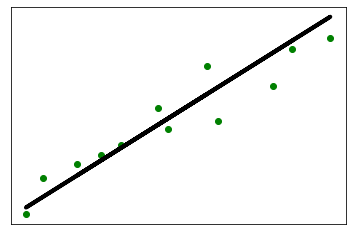

Linear regressor performance:
Mean absolute error = 0.59
Mean squared error = 0.49
Median absolute error = 0.51
Explain variance score = 0.86
R2 score = 0.86

New mean absolute error = 0.59


In [9]:

# Input file containing data
input_file = 'data_singlevar_regr.txt' 

# Read data
data = np.loadtxt(input_file, delimiter=',')
X, y = data[:, :-1], data[:, -1]

# Train and test split
num_training = int(0.8 * len(X))
num_test = len(X) - num_training

# Training data
X_train, y_train = X[:num_training], y[:num_training]

# Test data
X_test, y_test = X[num_training:], y[num_training:]

# Create linear regressor object
regressor = linear_model.LinearRegression()

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Predict the output
y_test_pred = regressor.predict(X_test)

# Plot outputs
plt.scatter(X_test, y_test, color='green')
plt.plot(X_test, y_test_pred, color='black', linewidth=4)
plt.xticks(())
plt.yticks(())
plt.show()

# Compute performance metrics
print("Linear regressor performance:")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

# Model persistence
output_model_file = 'model.pkl'

# Save the model
with open(output_model_file, 'wb') as f:
    pickle.dump(regressor, f)

# Load the model
with open(output_model_file, 'rb') as f:
    regressor_model = pickle.load(f)

# Perform prediction on test data
y_test_pred_new = regressor_model.predict(X_test)
print("\nNew mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred_new), 2))



## Building a multivariable regressor

In [10]:

# Input file containing data
input_file = 'data_multivar_regr.txt'

# Load the data from the input file
data = np.loadtxt(input_file, delimiter=',')
X, y = data[:, :-1], data[:, -1]

# Split data into training and testing 
num_training = int(0.8 * len(X))
num_test = len(X) - num_training

# Training data
X_train, y_train = X[:num_training], y[:num_training]

# Test data
X_test, y_test = X[num_training:], y[num_training:]

# Create the linear regressor model
linear_regressor = linear_model.LinearRegression()

# Train the model using the training sets
linear_regressor.fit(X_train, y_train)

# Predict the output
y_test_pred = linear_regressor.predict(X_test)

# Measure performance
print("Linear Regressor performance:")
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2))
print("Explained variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

# Polynomial regression
polynomial = preprocessing.PolynomialFeatures(degree=10)
X_train_transformed = polynomial.fit_transform(X_train)
datapoint = [[7.75, 6.35, 5.56]]
poly_datapoint = polynomial.fit_transform(datapoint)

poly_linear_model = linear_model.LinearRegression()
poly_linear_model.fit(X_train_transformed, y_train)
print("\nLinear regression:\n", linear_regressor.predict(datapoint))
print("\nPolynomial regression:\n", poly_linear_model.predict(poly_datapoint))



Linear Regressor performance:
Mean absolute error = 3.58
Mean squared error = 20.31
Median absolute error = 2.99
Explained variance score = 0.86
R2 score = 0.86

Linear regression:
 [36.05286276]

Polynomial regression:
 [41.45562492]


## Estimating housing prices using a Support Vector Regressor



In [20]:
# Load housing data
data = datasets.load_boston() 

# Shuffle the data
X, y = shuffle(data.data, data.target, random_state=7)

# Split the data into training and testing datasets 
num_training = int(0.8 * len(X))
X_train, y_train = X[:num_training], y[:num_training]
X_test, y_test = X[num_training:], y[num_training:]

# Create Support Vector Regression model
sv_regressor = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Train Support Vector Regressor
sv_regressor.fit(X_train, y_train)

# Evaluate performance of Support Vector Regressor
y_test_pred = sv_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
evs = explained_variance_score(y_test, y_test_pred) 
print("\n#### Performance ####")
print("Mean squared error =", round(mse, 2))
print("Explained variance score =", round(evs, 2))

# Test the regressor on test datapoint
test_data = [3.7, 0, 18.4, 1, 0.87, 5.95, 91, 2.5052, 26, 666, 20.2, 351.34, 15.27]
print("\nPredicted price:", sv_regressor.predict([test_data])[0])



#### Performance ####
Mean squared error = 106.93
Explained variance score = -0.25

Predicted price: 1.273909384763904


c:\Users\jko2\Anaconda3\envs\test\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing d